In [58]:

import anndata
import numpy as np
import pandas as pd
import re
import scanpy as sc
import scikit_posthocs as sp
import scipy
import seaborn as sns
import statsmodels
import datatable as dt
#custom functions
#import helper_functions_published #see file in Github

import sklearn
import os


In [3]:
#download and gunzip the supplementary files from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE193531
os.chdir("C:/Users/17347/Desktop/Boiarsky-etal-2022-master")


metadata_file = "data/GSE193531_cell-level-metadata.csv.gz"
umi_file = "data/GSE193531_umi-count-matrix.csv.gz"

cell_info_file = "data/supplementary_tables/cell_info.csv"
NMF_signatures_descriptions_file = "data/NMF_sig_desc.csv"


H_matrix_file = "data/H_matrix.csv"
W_matrix_file = "data/W_matrix.csv"


In [29]:
umi = dt.fread(umi_file) #for fast csv reading
umi = umi.to_pandas()
umi.index = umi.C0.tolist()
umi.drop(columns="C0", inplace=True)
umi = umi.astype("float64").transpose()

In [30]:
metadata = pd.read_csv(metadata_file, index_col=0)

In [31]:
cd138_adata = anndata.AnnData(X=umi, obs=metadata)

In [32]:
cd138_adata.obs = metadata

In [17]:
cd138_adata

AnnData object with n_obs × n_vars = 29387 × 22273
    obs: 'sample_ID', 'disease_stage', 'n_genes', 'frac_mito', 'n_counts', 'cluster', 'normal_or_neoplastic'
    layers: 'umi_counts'

In [33]:
#order samples by disease stage (useful for visualization)
#order for plotting
cd138_adata.obs.sample_ID = pd.Categorical(cd138_adata.obs.sample_ID, categories=[
    'NBM-1', 'NBM-2', 'NBM-3', 'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11', 
    'MGUS-1', 'MGUS-2', 'MGUS-3', 'MGUS-4', 'MGUS-5', 'MGUS-6', 
    'SMM-1', 'SMM-2', 'SMM-3', 
    'SMM-4', 'SMM-5', 'SMM-6', 'SMM-7', 'SMM-8', 'SMM-9', 'SMM-10', 'SMM-11', 'SMM-12',
    'MM-1', 'MM-2', 'MM-3', 'MM-4', 'MM-5', 'MM-6', 'MM-7', 'MM-8'], ordered=True)

cd138_adata.obs.disease_stage = pd.Categorical(cd138_adata.obs.disease_stage, categories=[
    'NBM', 'MGUS','SMM', 'MM'], ordered=True)

In [34]:
#change nans from string to NA
cd138_adata.obs.loc[cd138_adata.obs.normal_or_neoplastic=="nan","normal_or_neoplastic"]=None

cd138_adata.obs.normal_or_neoplastic = pd.Categorical(cd138_adata.obs.normal_or_neoplastic)

cd138_adata.obs.normal_or_neoplastic = cd138_adata.obs.normal_or_neoplastic.cat.remove_unused_categories()

In [35]:
#save raw umi's in a layer called 'umi_counts'
cd138_adata.layers['umi_counts'] = cd138_adata.X

In [ ]:
#we write the topgenes from each signature to a csv, treat CCND1 as a response 

topg = ['CCND1','JUNB','MTDH','HLA-DRA','HIST1H1C','DUSP4','IFI6','ITGB7','LGALS1','RPL36A','HIST1H4C','SAT1','FOS','KLF6','AREG','CD27','EIF3L','JUN','CST3','HNRNPH1','HSPA5','TMSB4X','FRZB','ISG15','UBC','HLA-A','NEAT1','CXCR4']

#anndata.AnnData.write_csvs(cd138_adata[:,topg].layers['lognorm'],dirname = "C:/Users/17347/Desktop/Boiarsky-etal-2022-master")

df =  pd.DataFrame(cd138_adata[:,topg].layers['lognorm'],columns = topg)

df.to_csv("C:/Users/17347/Desktop/Boiarsky-etal-2022-master/topgenes.csv")

In [ ]:
df2 = pd.DataFrame(cd138_adata.obs['sample_ID'])
df2.to_csv("C:/Users/17347/Desktop/Boiarsky-etal-2022-master/sampleID.csv")

In [ ]:
df3 = pd.DataFrame(cd138_adata.obs['normal_or_neoplastic'])
df3.to_csv("C:/Users/17347/Desktop/Boiarsky-etal-2022-master/normal_or_neoplastic.csv")

C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

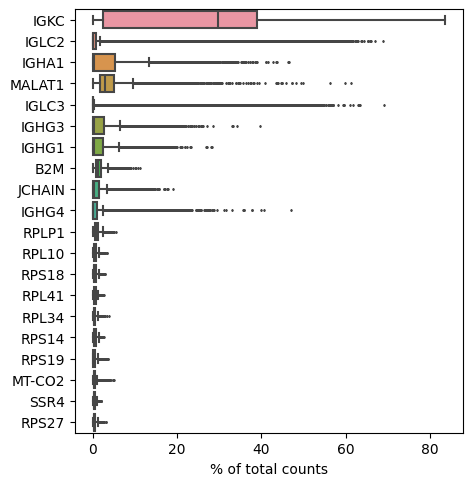

In [21]:
sc.pl.highest_expr_genes(cd138_adata, n_top=20)

In [36]:
#normalize the counts of cells
sc.pp.normalize_total(cd138_adata, target_sum=1e4, exclude_highly_expressed=True, max_fraction=0.2)
#log transform the data
sc.pp.log1p(cd138_adata)

In [37]:
cd138_adata.layers['lognorm'] = cd138_adata.X.copy() #log_normalized; this will match raw slot
cd138_adata.raw = cd138_adata

In [38]:
sc.pp.highly_variable_genes(cd138_adata, layer='lognorm', min_mean=0.0125, max_mean=4, min_disp=0.5)

C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [39]:
# remove Ig genes, sex genes from HVG list
sex_genes = ['XIST', 'RPS4Y1']
#ig_genes = list(pd.read_csv(ig_genes_file).iloc[:,0])
cd138_adata.var.loc[cd138_adata.var.index.isin(sex_genes),'highly_variable'] = False

In [40]:
# hemoglobin genes -- likely contamination
r = re.compile("^HB.*")
hemoglobin_genes = list(filter(r.match, cd138_adata.var.index))
#by manual inspection, not all of these are hemoglobin genes, remove those
hemoglobin_genes.remove("HBEGF")
hemoglobin_genes.remove("HBS1L")
hemoglobin_genes.remove("HBP1")

In [41]:
cd138_adata.obs['hemoglobin_score'] = cd138_adata[:,hemoglobin_genes].layers['lognorm'].sum(axis=1)

In [75]:
ccnd1gene = ['CCND1']

In [44]:
#this can take a few minutes
sc.pp.regress_out(cd138_adata, keys='hemoglobin_score')

In [ ]:
sc.pp.scale(cd138_adata, max_value=10)


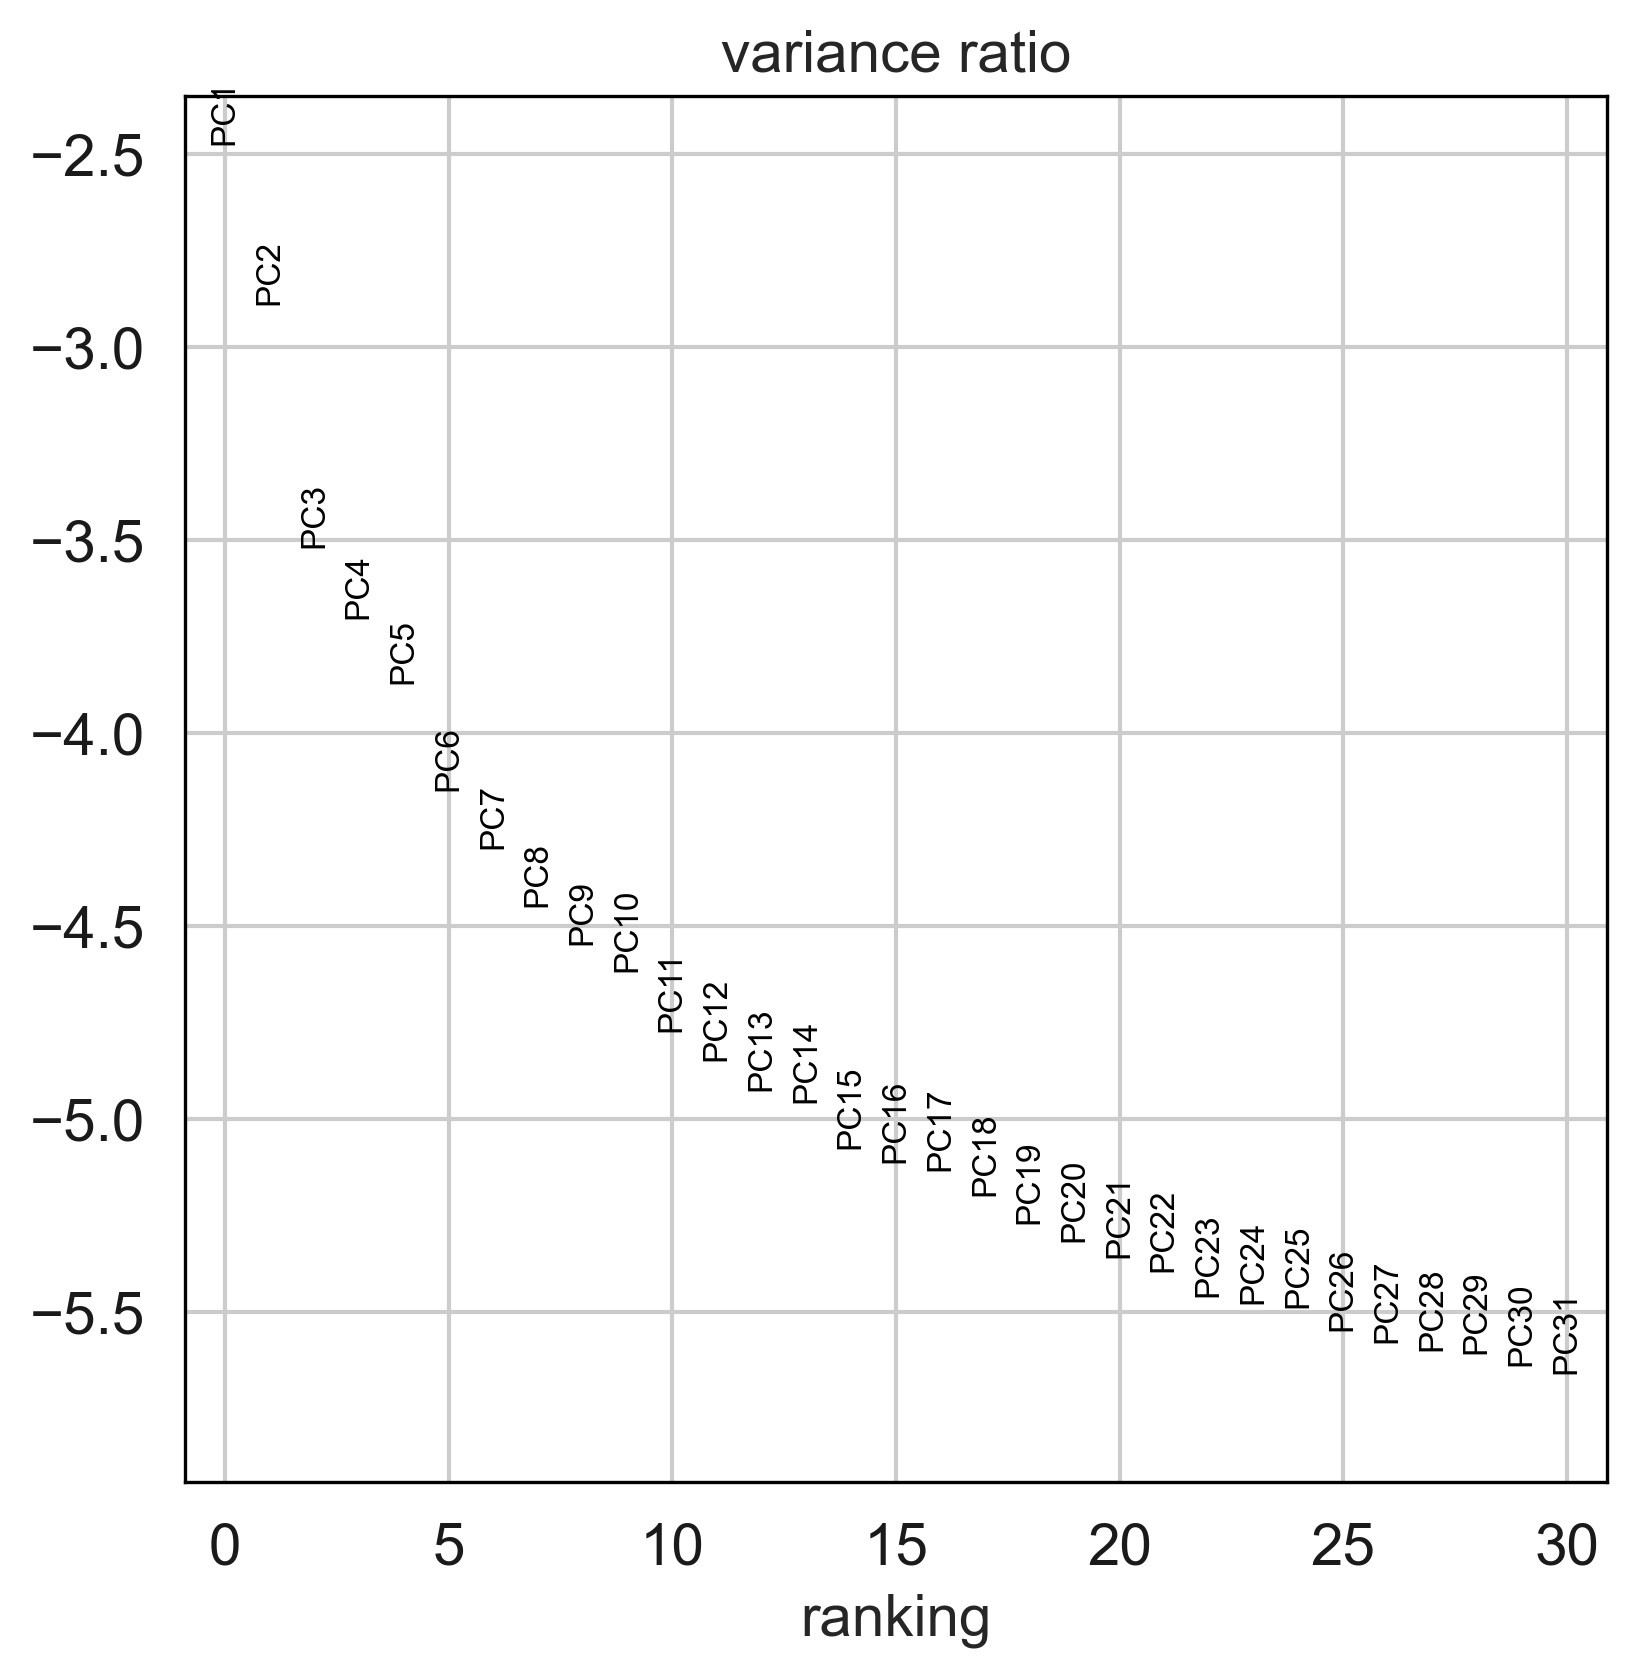

In [76]:
cd138_adata.var.loc[cd138_adata.var.index.isin(ccnd1gene),'highly_variable'] = False



sc.tl.pca(cd138_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(cd138_adata, log=True)



In [77]:
cd138_adata.var.highly_variable['CCND1']

False

In [ ]:
sc.pp.neighbors(cd138_adata, n_neighbors=15, n_pcs=14)


In [37]:
cd138_adata

AnnData object with n_obs × n_vars = 29387 × 22273
    obs: 'sample_ID', 'disease_stage', 'n_genes', 'frac_mito', 'n_counts', 'cluster', 'normal_or_neoplastic', 'hemoglobin_score'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'umi_counts', 'lognorm'

In [78]:
df5 = pd.DataFrame(cd138_adata.obsm['X_pca'])
df5.to_csv("C:/Users/17347/Desktop/Boiarsky-etal-2022-master/X_pcaNoCCND1.csv")

In [4]:
H = pd.read_csv(H_matrix_file, index_col=0)

In [5]:
W = pd.read_csv(W_matrix_file, index_col=0)  #supplied in source data

In [6]:
Sidx=W.columns

In [7]:
Sidx

Index(['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11',
       'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W20', 'W21',
       'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28'],
      dtype='object')

In [13]:
H=H.T

In [9]:
signatures_desc = pd.read_csv(NMF_signatures_descriptions_file) 
signatures_desc = signatures_desc[0:28]

In [10]:
signatures_desc

,signature,description,type,top_genes
0,W1,unknown,NaN,"['JUNB', 'ZFP36', 'NFKBIA', 'IER2']"
1,W2,MM-1,patient specific,"['MTDH', 'HLA-A', 'IFI27', 'SNHG25']"
2,W3,t(11;14) associated,NaN,"['CCND1', 'TSC22D3', 'RP5-887A10.1', 'RGS13']"
3,W4,HLA class II,NaN,"['HLA-DRA', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1']"
4,W5,histones,NaN,"['HIST1H1C', 'HIST1H2AC', 'HIST1H2BC', 'KIAA05..."
5,W6,unknown,NaN,"['DUSP4', 'GADD45A', 'BTG2', 'LAMP5']"
6,W7,MM-4,patient specific,"['IFI6', 'PTP4A3', 'HLA-A', 'LAG3']"
7,W8,t(14;20) associated,NaN,"['ITGB7', 'AC233755.2', 'SPP1', 'CCND2']"
8,W9,extracellular signaling,NaN,"['LGALS1', 'VIM', 'ACTB', 'S100A6']"
9,W10,RPL36A,single gene,"['RPL36A', 'NBEAL1', 'IFITM1', 'LAMP5']"


In [14]:

UE = W[Sidx]*H[Sidx].sum() #total activity for this gene, from this signature (multiply gene activity in signature by the sum of cellular activity from this signature)
FE = (UE.T/UE.T.sum()).T #how much of the genes' activity comes from this signature (specificity of gene to signature)

R=W[Sidx]*FE[Sidx]


In [15]:
R

,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,...,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28
ISG15,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,1.923600e-05,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.434278,0.000000e+00,0.000000e+00,0.000000,0.0
TNFRSF18,0.000000,0.000000,0.000665,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,4.517129e-04,0.000000,0.0
TNFRSF4,0.000000,0.000000,0.000255,0.000000e+00,0.0,4.074576e-06,0.000000e+00,2.321276e-07,0.000000e+00,0.000000e+00,...,3.150416e-06,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,2.780859e-04,0.000000,0.0
B3GALT6,0.000014,0.000007,0.000000,5.635279e-07,0.0,0.000000e+00,4.948417e-07,1.517859e-06,1.241409e-05,1.190181e-06,...,1.361995e-07,0.0,0.0,0.0,0.000006,0.000000,0.000000e+00,8.208711e-07,0.000016,0.0
ACAP3,0.000009,0.000003,0.000012,0.000000e+00,0.0,0.000000e+00,4.193953e-06,1.905736e-06,4.926842e-07,2.894783e-06,...,1.395023e-05,0.0,0.0,0.0,0.000003,0.000000,0.000000e+00,0.000000e+00,0.000091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.2,0.000000,0.000469,0.000000,0.000000e+00,0.0,3.448606e-07,4.129871e-07,8.292158e-07,0.000000e+00,1.154787e-05,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0
AL354822.1,0.000000,0.000023,0.000000,0.000000e+00,0.0,2.612268e-07,1.692931e-07,0.000000e+00,0.000000e+00,7.221152e-09,...,1.847749e-06,0.0,0.0,0.0,0.000000,0.000000,6.047184e-07,0.000000e+00,0.000007,0.0
AC004556.1,0.000002,0.000000,0.000039,0.000000e+00,0.0,0.000000e+00,0.000000e+00,3.740841e-04,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000645,0.000000,0.000000e+00,4.290134e-06,0.000000,0.0
AC233755.2,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,4.772810e-02,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0


In [25]:
top_genes = []
for sig in signatures_desc.signature:
    top_genes.append(list(R[sig].sort_values(ascending=False)[:5].index))

In [26]:
top_genes

[['JUNB', 'ZFP36', 'NFKBIA', 'IER2', 'GADD45B'],
 ['MTDH', 'HLA-A', 'IFI27', 'SNHG25', 'CCL3'],
 ['CCND1', 'TSC22D3', 'RP5-887A10.1', 'RGS13', 'RP11-211G23.2'],
 ['HLA-DRA', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1'],
 ['HIST1H1C', 'HIST1H2AC', 'HIST1H2BC', 'KIAA0556', 'ZBTB37'],
 ['DUSP4', 'GADD45A', 'BTG2', 'LAMP5', 'CD79A'],
 ['IFI6', 'PTP4A3', 'HLA-A', 'LAG3', 'IFI27'],
 ['ITGB7', 'AC233755.2', 'SPP1', 'CCND2', 'CCL1'],
 ['LGALS1', 'VIM', 'ACTB', 'S100A6', 'HLA-A'],
 ['RPL36A', 'NBEAL1', 'IFITM1', 'LAMP5', 'COMMD3'],
 ['HIST1H4C', 'STMN1', 'TUBA1B', 'HMGB2', 'KIAA0101'],
 ['SAT1', 'S100A9', 'S100A8', 'CRIP1', 'LYZ'],
 ['FOS', 'RPPH1', 'ID1', 'CDKL3', 'AC011747.4'],
 ['KLF6', 'TSC22D3', 'ANKRD28', 'KLF2', 'YPEL5'],
 ['AREG', 'KLF4', 'NEAT1', 'CTA-292E10.6', 'COMMD3'],
 ['CD27', 'CD79A', 'TXNIP', 'JSRP1', 'ITM2C'],
 ['EIF3L', 'MYC', 'RPL36A', 'JUNB', 'ADM'],
 ['JUN', 'FOSB', 'EGR1', 'IER2', 'HSPB1'],
 ['CST3', 'ITM2C', 'MTDH', 'TIMP1', 'AZGP1'],
 ['HNRNPH1', 'PIM2', 'C16orf54', 

In [27]:
top_genes = ['CCND1']
for sig in signatures_desc.signature:
    if sig != 'W3':
        for ge in list(R[sig].sort_values(ascending=False)[:5].index):
            top_genes.append(ge)

In [28]:
top_genes

['CCND1',
 'JUNB',
 'ZFP36',
 'NFKBIA',
 'IER2',
 'GADD45B',
 'MTDH',
 'HLA-A',
 'IFI27',
 'SNHG25',
 'CCL3',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DPA1',
 'HLA-DPB1',
 'HLA-DQA1',
 'HIST1H1C',
 'HIST1H2AC',
 'HIST1H2BC',
 'KIAA0556',
 'ZBTB37',
 'DUSP4',
 'GADD45A',
 'BTG2',
 'LAMP5',
 'CD79A',
 'IFI6',
 'PTP4A3',
 'HLA-A',
 'LAG3',
 'IFI27',
 'ITGB7',
 'AC233755.2',
 'SPP1',
 'CCND2',
 'CCL1',
 'LGALS1',
 'VIM',
 'ACTB',
 'S100A6',
 'HLA-A',
 'RPL36A',
 'NBEAL1',
 'IFITM1',
 'LAMP5',
 'COMMD3',
 'HIST1H4C',
 'STMN1',
 'TUBA1B',
 'HMGB2',
 'KIAA0101',
 'SAT1',
 'S100A9',
 'S100A8',
 'CRIP1',
 'LYZ',
 'FOS',
 'RPPH1',
 'ID1',
 'CDKL3',
 'AC011747.4',
 'KLF6',
 'TSC22D3',
 'ANKRD28',
 'KLF2',
 'YPEL5',
 'AREG',
 'KLF4',
 'NEAT1',
 'CTA-292E10.6',
 'COMMD3',
 'CD27',
 'CD79A',
 'TXNIP',
 'JSRP1',
 'ITM2C',
 'EIF3L',
 'MYC',
 'RPL36A',
 'JUNB',
 'ADM',
 'JUN',
 'FOSB',
 'EGR1',
 'IER2',
 'HSPB1',
 'CST3',
 'ITM2C',
 'MTDH',
 'TIMP1',
 'AZGP1',
 'HNRNPH1',
 'PIM2',
 'C16orf54',
 'PHKG1',
 'C1orf5

In [45]:
df =  pd.DataFrame(cd138_adata[:,top_genes].layers['lognorm'],columns = top_genes)

df.to_csv("C:/Users/17347/Desktop/Boiarsky-etal-2022-master/topgenes.csv")


In [46]:
topg = ['CCND1','JUNB','MTDH','HLA-DRA','HIST1H1C','DUSP4','IFI6','ITGB7','LGALS1','RPL36A','HIST1H4C','SAT1','FOS','KLF6','AREG','CD27','EIF3L','JUN','CST3','HNRNPH1','HSPA5','TMSB4X','FRZB','ISG15','UBC','HLA-A','NEAT1','CXCR4']
df =  pd.DataFrame(cd138_adata[:,topg].layers['lognorm'],columns = topg)
df.to_csv("C:/Users/17347/Desktop/Boiarsky-etal-2022-master/topgenes.csv")


In [48]:
R['max'] = R.max(axis=1)
R['max_id'] = np.argmax(R.values,axis=1)+1

In [49]:
df_top_genes_sigs = R.reset_index().rename(columns={"index":"gene"}).drop(columns=['max', 'max_id']).melt(id_vars="gene", var_name="signature").rename(columns={"value":"relative importance"}).sort_values(['signature','relative importance'], ascending=False).groupby('signature').head(10)
#limit figure to 'biologically interpretable' signatures
df_top_genes_sigs = df_top_genes_sigs.merge(signatures_desc[(pd.isna(signatures_desc.type))&(~(signatures_desc.description=="unknown"))], on="signature")
df_top_genes_sigs.loc[df_top_genes_sigs.description=="protein synthesis (ser/thr kinase; elongation factors; pre/mRNA editing)","description"]="protein synthesis"
df_top_genes_sigs['title'] = df_top_genes_sigs.signature+": "+df_top_genes_sigs.description

In [50]:

#for figure, I want there to be 9 facets, not 10. will drop 'extracellular signaling' and 'nuclear genes' (the latter is just a QC issue due to some cells having high MALAT1)
df_top_genes_sigs = df_top_genes_sigs[df_top_genes_sigs.signature!="W9"]
df_top_genes_sigs = df_top_genes_sigs[df_top_genes_sigs.signature!="W27"]

C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\categorical.py:3203: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors

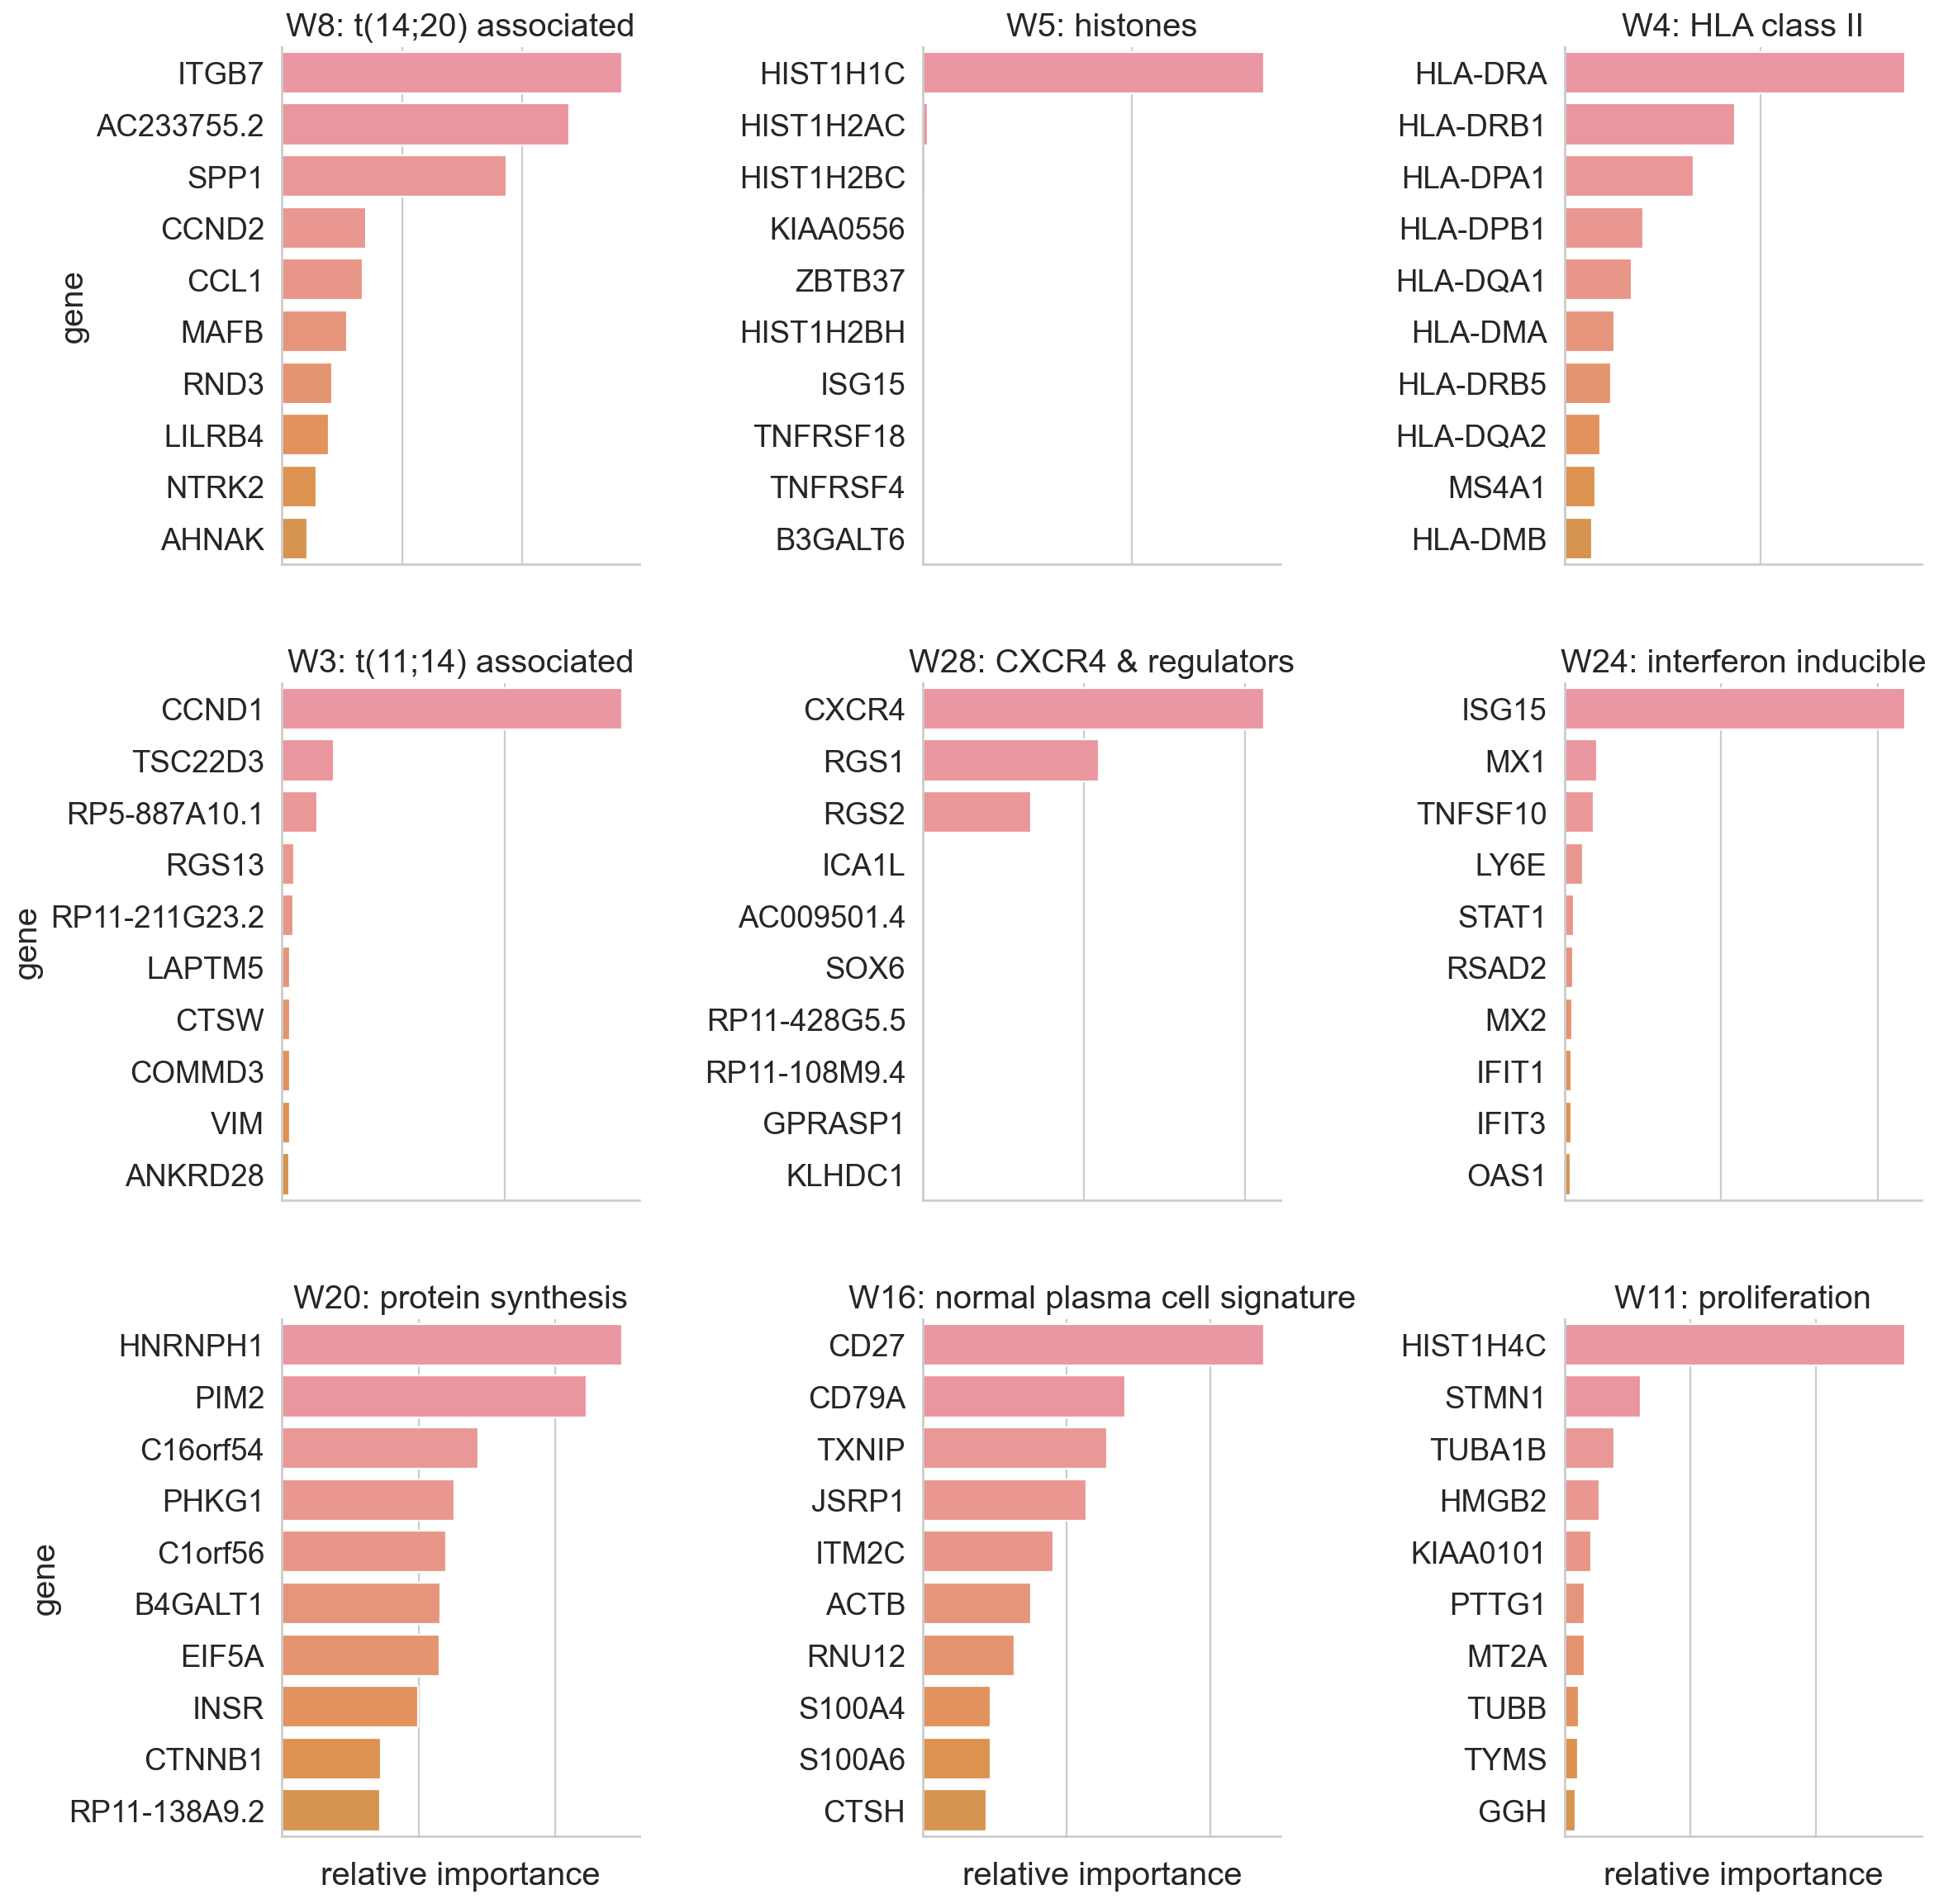

In [51]:

sc.settings.set_figure_params(dpi=80, facecolor='white', format='png')
sns.set(style="whitegrid", font_scale=1.5)
g = sns.catplot(data=df_top_genes_sigs, y="gene", x="relative importance", col="title", col_wrap=3, kind="bar", sharex=False, sharey=False)
g.set_titles(template='{col_name}')
g.set(xticklabels=[]) #no need for xtick labels

In [53]:
cd138_adata.obs = cd138_adata.obs.join(H)


In [54]:
cd138_adata.obs['log'+H.columns] = np.log10(H[H.columns]+1)


C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical

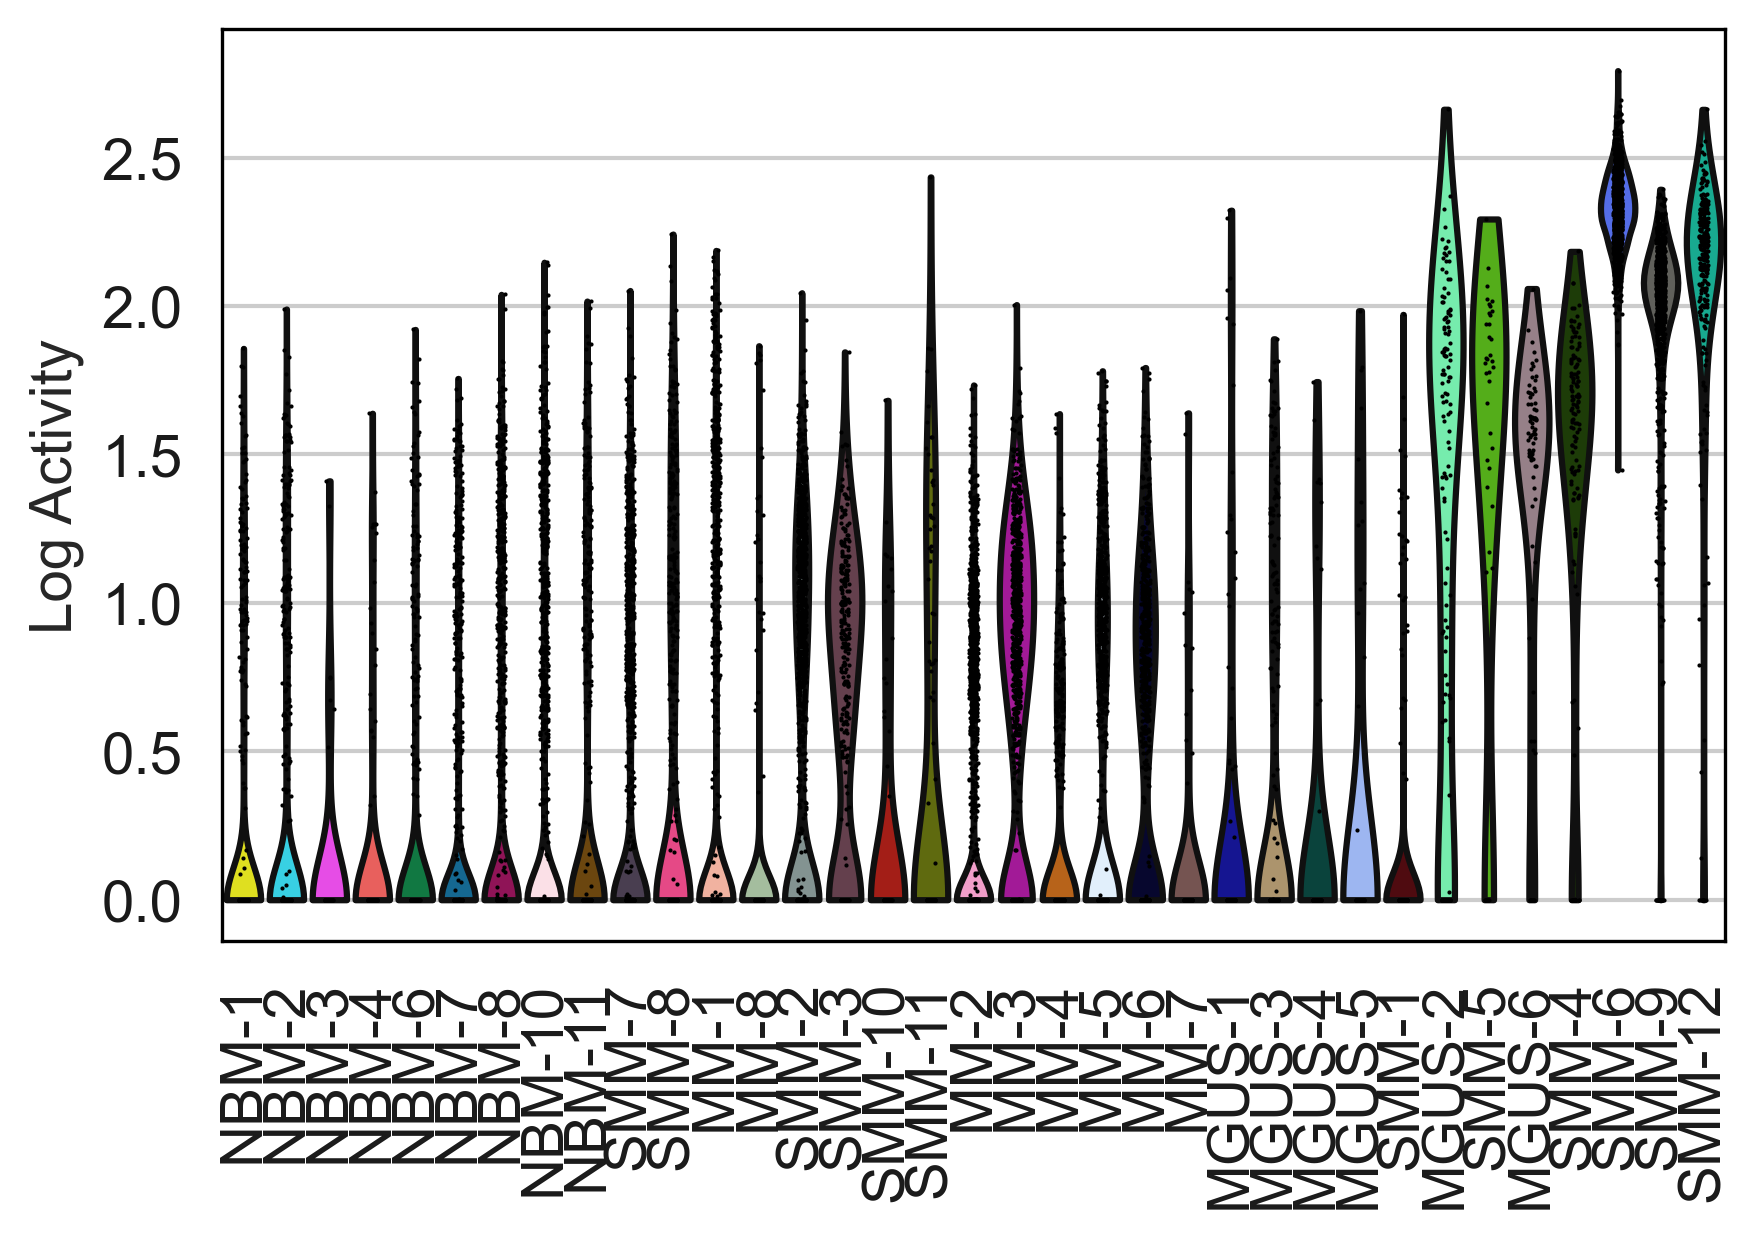

In [55]:
sc.settings.set_figure_params(figsize=[6,4], dpi=150, format='png')
sc.pl.violin(cd138_adata, keys="logW3", groupby="sample_ID", rotation=90, ylabel="Log Activity",
    order=[
    'NBM-1', 'NBM-2', 'NBM-3', 'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11', #NBM
    'SMM-7', 'SMM-8', 'MM-1', #t(4;14)
    'MM-8', #t(14;20)
    'SMM-2', 'SMM-3','SMM-10', 'SMM-11', 'MM-2', 'MM-3', 'MM-4','MM-5', 'MM-6','MM-7', #hyperdiploid (only. some translocated are also HRD)
    'MGUS-1', 'MGUS-3', 'MGUS-4', 'MGUS-5', 'SMM-1', 'MGUS-2','SMM-5', #insufficient cells
     'MGUS-6', 'SMM-4', 'SMM-6', 'SMM-9', 'SMM-12', #t(11;14)    
    ])
sc.settings.set_figure_params(figsize=[6,6], dpi=150, format='png')

In [56]:
sc.tl.pca(cd138_adata, svd_solver='arpack')

In [72]:
cd138_adata

AnnData object with n_obs × n_vars = 29387 × 22273
    obs: 'sample_ID', 'disease_stage', 'n_genes', 'frac_mito', 'n_counts', 'cluster', 'normal_or_neoplastic', 'hemoglobin_score', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W20', 'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28', 'logW1', 'logW2', 'logW3', 'logW4', 'logW5', 'logW6', 'logW7', 'logW8', 'logW9', 'logW10', 'logW11', 'logW12', 'logW13', 'logW14', 'logW15', 'logW16', 'logW17', 'logW18', 'logW19', 'logW20', 'logW21', 'logW22', 'logW23', 'logW24', 'logW25', 'logW26', 'logW27', 'logW28', 'leiden', 'cluster4'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'sample_ID_colors', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'umi_counts', 'lognorm'
    obsp: 'distances', 'connectivities'

In [73]:
df5 = pd.DataFrame(cd138_adata.obsm['X_pca'])
df5.to_csv("C:/Users/17347/Desktop/Boiarsky-etal-2022-master/X_pcaNoCCND1.csv")

In [62]:
model3 =  sklearn.mixture.GaussianMixture(n_components=25).fit(cd138_adata.obsm['X_pca'][:,0:21])
labels3 = model3.predict(cd138_adata.obsm['X_pca'][:,0:21])
labs3 = pd.Categorical(labels3)
cd138_adata2.obs['cluster5'] = labs3
sc.pl.umap(cd138_adata, color="cluster5")

AttributeError: module 'sklearn' has no attribute 'mixture'

In [63]:
sc.pp.neighbors(cd138_adata, n_neighbors=15, n_pcs=13)

C:\Users\17347\anaconda3\envs\proj1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
sc.tl.leiden(cd138_adata,resolution = 0.6)

In [70]:
cd138_adata.obs['cluster4']= cd138_adata.obs['leiden']

In [71]:
sc.pl.umap(cd138_adata, color="cluster")

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [67]:
cd138_adata

AnnData object with n_obs × n_vars = 29387 × 22273
    obs: 'sample_ID', 'disease_stage', 'n_genes', 'frac_mito', 'n_counts', 'cluster', 'normal_or_neoplastic', 'hemoglobin_score', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W20', 'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28', 'logW1', 'logW2', 'logW3', 'logW4', 'logW5', 'logW6', 'logW7', 'logW8', 'logW9', 'logW10', 'logW11', 'logW12', 'logW13', 'logW14', 'logW15', 'logW16', 'logW17', 'logW18', 'logW19', 'logW20', 'logW21', 'logW22', 'logW23', 'logW24', 'logW25', 'logW26', 'logW27', 'logW28', 'leiden', 'cluster4'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'sample_ID_colors', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'umi_counts', 'lognorm'
    obsp: 'distances', 'connectivities'